# `Filtering and coarse-graining operators`

In this notebook, we'll very briefly go over the different filtering and coarse-graining operators we test in the paper.

In [1]:
import os
import sys
import pyqg
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
import functions.coarsening_ops as coarsening
from pyqg.diagnostic_tools import calc_ispec as _calc_ispec

%matplotlib inline
plt.rcParams.update({'font.size': 13})
calc_ispec = lambda *args, **kwargs: _calc_ispec(*args, averaging = False, truncate =False, **kwargs)

## `1 - Initialization of HR and LR models`

In order to have something to filter and coarse-grain, let's run a model:

In [3]:
m1 = pyqg.QGModel(nx = 256, dt = 3600., log_level=0)
for i in tqdm(range(5000)):
    m1._step_forward()

  0%|          | 0/5000 [00:00<?, ?it/s]

## A -  Initialize our filtering and coarse-graining operators

See our paper for more details on how these are defined; the main point here is that there are many options which lead to qualitatively different results!

In [4]:
op1 = coarsening.Operator1(m1, 64) # spectral truncation + sharp filter
op2 = coarsening.Operator2(m1, 64) # spectral truncation + softer Gaussian filter
op3 = coarsening.Operator3(m1, 64) # GCM-Filters + real-space coarsening
ops = [op1, op2, op3]

INFO:  Logger initialized
INFO:  Logger initialized
INFO:  Logger initialized


## B - Visualize effects on $q_1$

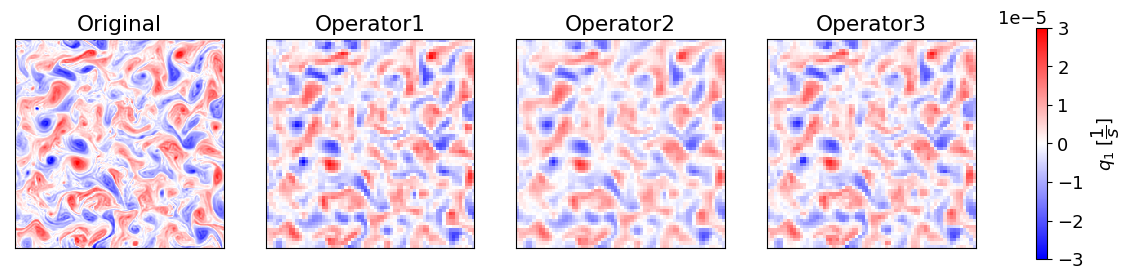

In [19]:
# Allows to plot an image
def imshow(arr, vlim=3e-5):
    plt.xticks([]); plt.yticks([])
    return plt.imshow(arr, vmin=-vlim, vmax=vlim, cmap='bwr', interpolation='none')

# Initilization of the plot
fig = plt.figure(figsize = (15.5 , 3))
plt.subplot(1,4,1, title='Original')

# Plotting high resolution data
imshow(m1.q[0])

# Plotting coarse grained simulations
for j, op in enumerate(ops):
    plt.subplot(1,4,j+2, title=op.__class__.__name__)
    im = imshow(op.m2.q[0])

# Adding a colorbar to the figure
fig.colorbar(im, ax = fig.axes, pad = 0.05).set_label('$q_1$ [$\dfrac{1}{s}$]')

It's a bit hard to see the differences in the coarse-grained PV (Potential vorticity), but let's look at the forcing:

## C - Visualize effects on $S_{q_1}$

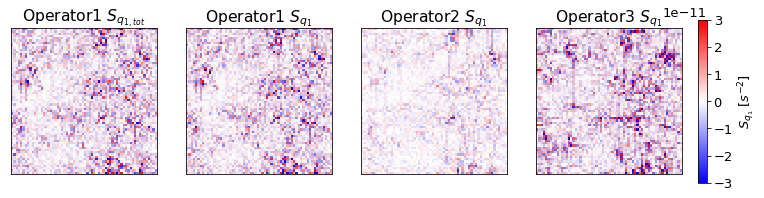

In [5]:
fig = plt.figure(figsize=(14.5,3))
plt.subplot(1,4,1, title='Operator1 $S_{q_{1,tot}}$')
imshow(op1.q_forcing_total[0], 3e-11)
for j, op in enumerate(ops):
    plt.subplot(1,4,j+2, title=op.__class__.__name__ + " $S_{q_1}$")
    im = imshow(op.subgrid_forcing('q')[0], 3e-11)
cb = fig.colorbar(im, ax=fig.axes, pad=0.02).set_label('$S_{q_1}$ [$s^{-2}$]')

- Compared to Operator 1 (spectral truncation + sharp filter), we see significantly less forcing with Operator 2 (spectral truncation + Gaussian filter). 


- With Operator 3 (GCM-Filters + real-space coarsening), we see a bit more forcing. 


The difference in magnitude of resulting forcing is explained by the difference in shape and width of resulting filtering and coarsegraining operation. We can also look at spectra:

Text(0.5, 0, 'Isotropic wavenumber')

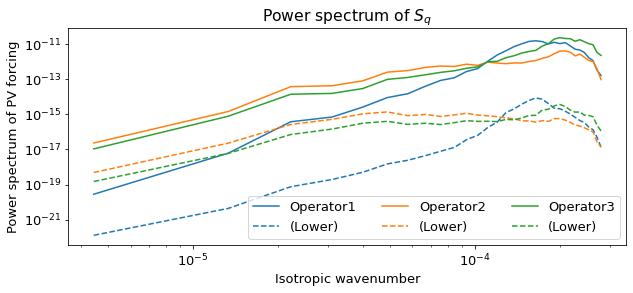

In [40]:
plt.figure(figsize=(10,4))
plt.title("Power spectrum of $S_{q}$")
for j, op in enumerate(ops):
    Sq = op.subgrid_forcing('q')
    line = plt.loglog(*calc_ispec(op.m2, np.abs(op.m2.fft(Sq))[0]**2), label=op.__class__.__name__)
    plt.loglog(*calc_ispec(op.m2, np.abs(op.m2.fft(Sq))[1]**2), color=line[0]._color, ls='--', label='(Lower)')
plt.legend(ncol=3)
plt.ylabel("Power spectrum of PV forcing")
plt.xlabel("Isotropic wavenumber")

Note to myself :
- If you read from right to left, the wavenumber decreases. Thus the frequency increases which explains why the power intensity decreases since we are suppose to loose high frequency information

We can see significant differences between operators and layers. Let's look at similar plots for velocity forcing:

## Visualize effects on $S_{u_1}$

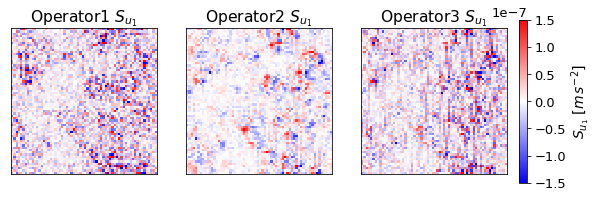

In [6]:
fig = plt.figure(figsize=(14.5,3))
for j, op in enumerate(ops):
    plt.subplot(1,4,j+2, title=op.__class__.__name__ + " $S_{u_1}$")
    im = imshow(op.subgrid_forcing('u')[0], 1.5e-7)
fig.colorbar(im, ax=fig.axes, pad=0.02).set_label('$S_{u_1}$ [$m\,s^{-2}$]', fontsize=14)

Text(0.5, 0, 'Isotropic wavenumber')

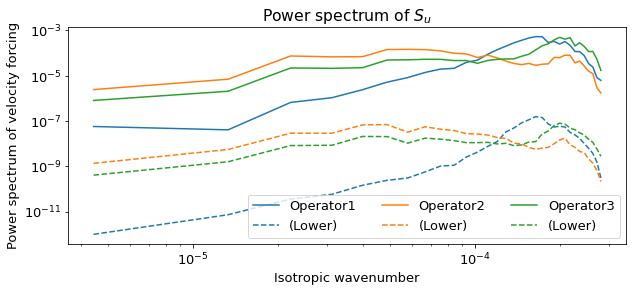

In [39]:
plt.figure(figsize=(10,4))
plt.title("Power spectrum of $S_{u}$")
for j, op in enumerate(ops):
    Su = op.subgrid_forcing('u')
    line = plt.loglog(*calc_ispec(op.m2, np.abs(op.m2.fft(Su))[0]**2), label=op.__class__.__name__)
    plt.loglog(*calc_ispec(op.m2, np.abs(op.m2.fft(Su))[1]**2), color=line[0]._color, ls='--', label='(Lower)')
plt.legend(ncol=3)
plt.ylabel("Power spectrum of velocity forcing")
plt.xlabel("Isotropic wavenumber")

We can also compute "subgrid flux" terms, whose divergence is equal to the subgrid forcing (in case we want to train models which obey conservation constraints without needing to enforce that architecturally). Let's look at the $x$-component of the lower-layer subgrid flux, just for fun:

## Visualize effects on $\phi_{q_2}$

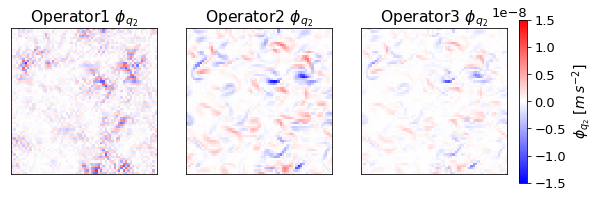

In [7]:
fig = plt.figure(figsize=(14.5,3))
for j, op in enumerate(ops):
    plt.subplot(1,4,j+1, title=op.__class__.__name__ + " $\phi_{q_2}$")
    uq, vq = op.subgrid_fluxes('q')
    im = imshow(uq[1], 1.5e-8)
fig.colorbar(im, ax=fig.axes, pad=0.02).set_label('$\phi_{q_2}$ [$m\,s^{-2}$]', fontsize=14)